In [141]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const

c = const.c.cgs.value

In [142]:
filename = '/Users/yaolun/data/hh168_texes/26/fits/IRXXX     _red.3003.fits'

In [143]:
hdulist = fits.open(filename)
im = hdulist[0].data
wno = hdulist[1].data
wave = 1/wno *1e4 # in um
# [Ne II] rest frame wavelength: 12.813548 um
dv = (12.813548 - wave) / 12.813548 * c/1e5
collapse_im = np.sum(im[127:155,:], axis=0)
collapse_bkg = (np.sum(im[80:127,:], axis=0)+np.sum(im[155:185,:], axis=0))/2

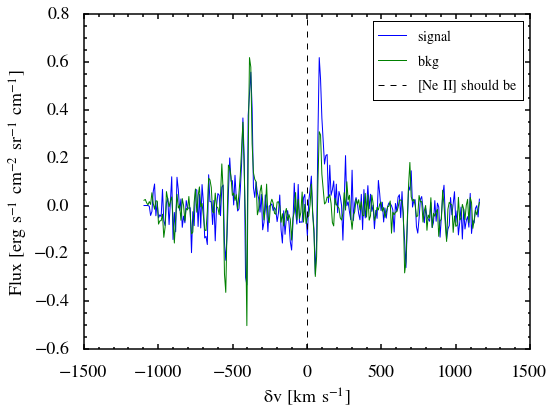

In [54]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
signal, = ax.plot(dv, collapse_im)
bkg, = ax.plot(dv, collapse_bkg*max(collapse_im)/max(collapse_bkg))
# plt.plot(wno, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
neii = ax.axvline(0, color='k', linestyle='--')

ax.legend([signal, bkg, neii], [r'$\rm{signal}$',r'$\rm{bkg}$',r'$\rm{[Ne\,II]\,should\,be}$'],fontsize=14,numpoints=1)

# ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}\,cm^{-1}]}$', fontsize=18)
ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig('/Users/yaolun/data/hh168_texes/3003_data.pdf',dpi=300, bbox_inches='tight',format='pdf')

###Getting the atmospheric line profiles

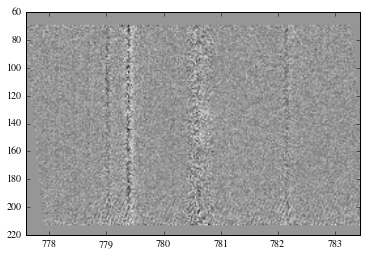

In [139]:
hdulist = fits.open(filename)
im_sub = hdulist[0].data
# 133 is the index of the peak of the blended line
# 203 is the index of the peak of atmospheric line on the right
im_sub[:,133-10:133+10] = im_sub[:,133-10:133+10] - im_sub[:,202-10:202+10]*1.2

# plt.plot(wno, collapse_im)
# plt.axvline(780.63806152)
# plt.axvline(782.2510376)
# print collapse_im[133]/collapse_im[203]
plt.imshow(im_sub[60:220,:], cmap='Greys_r', extent=[min(wno), max(wno),220,60],aspect='auto')

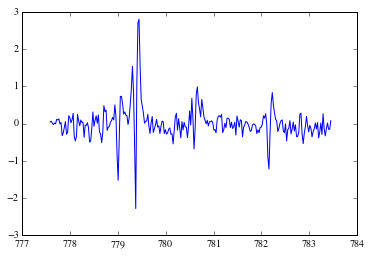

In [140]:
plt.plot(wno, np.sum(im_sub, axis=0))

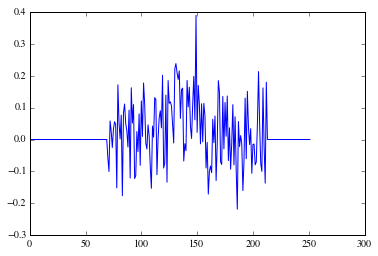

In [144]:
# collpase in wavenumber
flux = np.sum(im_sub[:,(wno > 780.5) & (wno < 781)], axis=1)
plt.plot(flux)

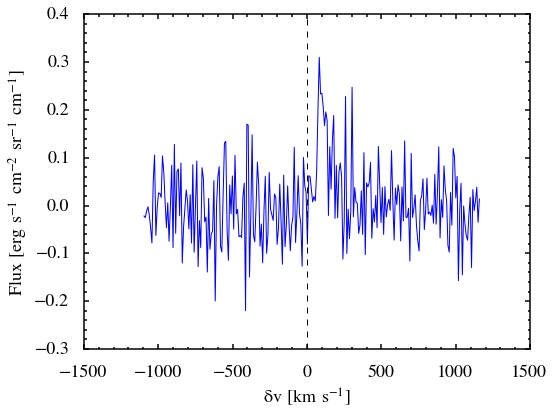

In [55]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(dv, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
ax.axvline(0, color='k', linestyle='--')

# ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}\,cm^{-1}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig('/Users/yaolun/data/hh168_texes/3003_signal.pdf',dpi=300, bbox_inches='tight',format='pdf')

In [50]:
print hdulist[0].header['RA']
print hdulist[0].header['Dec']
print hdulist[0].header

344.1818
62.09911
SIMPLE  =                    T                                                  BITPIX  =                  -32                                                  NAXIS   =                    2                                                  NAXIS1  =                  256                                                  NAXIS2  =                  252                                                  EXTEND  =                    T                                                  COMMENT   The primary HDU contains a 2-D spectral-spatial image                 COMMENT   The primary HDU is followed by four 1-D IMAGE extensions              COMMENT   giving the wavenumber scale (EXTNAME = WAVENUMBER),                   COMMENT   the extracted flux spectrum (EXTNAME = FLUX),                         COMMENT   the calculated 1-sigma noise in the flux (NOISE),                     COMMENT   and the telluric transmission spectrum calculated from                COMMENT   (black-sky)/

In [9]:
print hdulist.info()
# print hdulist[3].data

Filename: /Users/yaolun/data/hh168_texes/26/fits/IRXXX     _red.3003.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     121   (256, 252)   float32   
1    WAVENUMBER  ImageHDU         9   (256,)       float32   
2    FLUX        ImageHDU         9   (256,)       float32   
3    NOISE       ImageHDU         9   (256,)       float32   
4    ATMO        ImageHDU         9   (256,)       float32   
5    2-D-NOISE   ImageHDU        11   (256, 252)   float32   
None


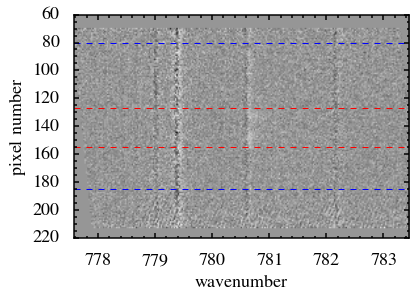

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im[60:220,:], cmap='Greys_r', extent=[min(wno), max(wno),220,60],aspect='auto')
ax.axhline(80, linestyle='--', color='Blue')
ax.axhline(127, linestyle='--', color='Red')
ax.axhline(155, linestyle='--', color='Red')
ax.axhline(185, linestyle='--', color='Blue')

ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
ax.set_ylabel(r'$\rm{pixel\,number}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig('/Users/yaolun/data/hh168_texes/3003_2dview_crop.pdf',dpi=300, bbox_inches='tight',format='pdf')

In [52]:
def plot_texes_neii(name, wno=False):

    from astropy.io import fits
    import numpy as np
    import matplotlib.pyplot as plt
    import astropy.constants as const

    c = const.c.cgs.value

    filename = '/Users/yaolun/data/hh168_texes/26/fits/IRXXX     _red.'+name+'.fits'
    hdulist = fits.open(filename)
    im = hdulist[0].data
    wno = hdulist[1].data
    wave = 1/wno *1e4 # in um
    # [Ne II] rest frame wavelength: 12.813548 um
    dv = (12.813548 - wave) / 12.813548 * c/1e5
    collapse_im = np.sum(im[127:155,:], axis=0)
    collapse_bkg = np.sum(im[80:127,:], axis=0)+np.sum(im[155:185,:], axis=0)

    # plot the signal collapsed spectrum and background collapsed spectrum
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    if wno:
        signal, = ax.plot(dv, collapse_im)
        bkg, = ax.plot(dv, collapse_bkg*max(collapse_im)/max(collapse_bkg))      
    else:
        signal, = ax.plot(dv, collapse_im)
        bkg, = ax.plot(dv, collapse_bkg*max(collapse_im)/max(collapse_bkg))
    # plt.plot(wno, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
    neii = ax.axvline(0, color='k', linestyle='--')

    ax.legend([signal, bkg, neii], [r'$\rm{signal}$',r'$\rm{bkg}$',r'$\rm{[Ne\,II]\,should\,be}$'],fontsize=14,numpoints=1)

    ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
    ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

    fig.savefig('/Users/yaolun/data/hh168_texes/'+name+'_data.pdf',dpi=300, bbox_inches='tight',format='pdf')
    fig.clf()
    
    # plot the sky subtracted spectrum
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    ax.plot(dv, collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg))
    ax.axvline(0, color='k', linestyle='--')

    ax.set_xlabel(r'$\rm{\delta v\,[km\,s^{-1}]}$', fontsize=18)
    ax.set_ylabel(r'$\rm{Flux\,[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

    fig.savefig('/Users/yaolun/data/hh168_texes/'+name+'_signal.pdf',dpi=300, bbox_inches='tight',format='pdf')
    fig.clf()
    
    # plot 2-D spectrum
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(im[60:220,:], cmap='Greys_r', extent=[min(wno), max(wno),220,60],aspect='auto')
    ax.axhline(80, linestyle='--', color='Blue')
    ax.axhline(127, linestyle='--', color='Red')
    ax.axhline(155, linestyle='--', color='Red')
    ax.axhline(185, linestyle='--', color='Blue')

    ax.set_xlabel(r'$\rm{wave number}$', fontsize=18)
    ax.set_ylabel(r'$\rm{pixel\,number}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
    ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

    fig.savefig('/Users/yaolun/data/hh168_texes/'+name+'_2dview_crop.pdf',dpi=300, bbox_inches='tight',format='pdf')
    fig.clf()
    
    # approximate the [Ne II] flux by adding up flux from wno=780.5 to 781
    im_signal = collapse_im-collapse_bkg*max(collapse_im)/max(collapse_bkg)
    flux_tot = np.sum(im_signal[(wno >= 780.5) & (wno <= 781)])
    
    return hdulist[0].header['RA'], hdulist[0].header['Dec'], flux_tot

In [53]:
ra = []
dec = []
flux_tot = []
for i in range(3003, 3017):
    ra_dum, dec_dum, flux_dum = plot_texes_neii(str(i))
    ra.append(ra_dum)
    dec.append(dec_dum)
    flux_tot.append(flux_dum)

(14,) (14,) (14,)


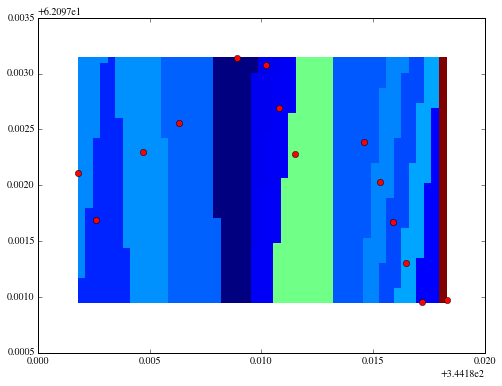

In [38]:
ra = np.array(ra)
dec = np.array(dec)
flux_tot = np.array(flux_tot)
from scipy.interpolate import griddata
x = np.linspace(min(ra), max(ra), 50)
y = np.linspace(min(dec), max(dec), 50)

z = griddata((ra, dec), flux_tot, (x[None,:], y[:,None]), method='nearest')
    
print np.shape(ra), np.shape(dec), np.shape(flux_tot)
# plt.imshow(z)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.pcolormesh(x, y, z)
ax.plot(ra, dec, 'ro')